# <font color='red'>WORK SOLELY DONE BY THOMAS DANIEL AND THEO CHICHERY.</font>

## The genetic algorithm class found in Part A is highly inspired by the class we coded in the AI Algorithm Project (biscuit manufacturing). It is also highly inspired by the last part of Lab session 3 that you can find in the Farah AIT SALAHT AI algorithm course. 

## The CSP problem found in Exercise 2 was highly inspired by the Lab session 4 (AI algorithm course by Farah AIT SALAHT)

## Exercise 1

## Part A

In [31]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import copy
import random
import matplotlib.pyplot as plt
import time as time

1. Dataset creation using the make_blobs from scikit-learn : 

In [ ]:
"""The parameters for the make blobs function are given in the homework subject"""
n_samples = 1000
centers = 2
n_features = 4
random_state = 42

# Generate synthetic dataset
X, y = make_blobs(n_samples=n_samples, centers=centers, n_features=n_features, random_state=random_state)
# Convert labels to binary (0 and 1)
y = y.reshape(-1, 1)

2. Neural network design & architecture :

In [ ]:
class NeuralNetwork:
    """Simple NN class. We initialize the weights with small values that will evolve later on."""
    def __init__(self, input_size, hidden_sizes, output_size):
        # Initialize weights and biases
        self.layers = []
        self.weights = []
        self.biases = []
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(self.layer_sizes)-1):
            # Initialize weights with small random values
            weight = np.random.uniform(-1, 1, (self.layer_sizes[i], self.layer_sizes[i+1]))
            bias = np.random.uniform(-1, 1, (1, self.layer_sizes[i+1]))
            self.weights.append(weight)
            self.biases.append(bias)
    
    def sigmoid(self, z):
        """Sigmoid function is used arbitrarily in the subject"""
        return 1 / (1 + np.exp(-z))
    
    def forward(self, X, weights, biases):
        """Function to push the data through the neural network"""
        a = X
        for w, b in zip(weights, biases):
            z = np.dot(a, w) + b
            a = self.sigmoid(z)
        return a

3. GA Implementation: 

Population initializer :

In [34]:
def initialize_population(pop_size, genome_length):
    population = []
    for _ in range(pop_size):
        # Initialize genome with random values between -1 and 1
        genome = np.random.uniform(-1, 1, genome_length)
        population.append(genome)
    return population

Genome function : 

In [35]:
def decode_genome(genome, layer_sizes):
    weights = []
    biases = []
    idx = 0
    for i in range(len(layer_sizes)-1):
        input_size = layer_sizes[i]
        output_size = layer_sizes[i+1]
        # Extract weights
        w_size = input_size * output_size
        w = genome[idx:idx+w_size].reshape(input_size, output_size)
        weights.append(w)
        idx += w_size
        # Extract biases
        b_size = output_size
        b = genome[idx:idx+b_size].reshape(1, output_size)
        biases.append(b)
        idx += b_size
    return weights, biases

Fitness function : 

In [36]:
def calculate_fitness(individual, nn, X, y):
    weights, biases = decode_genome(individual, nn.layer_sizes)
    predictions = nn.forward(X, weights, biases)
    mse = np.mean((predictions - y) ** 2)
    # Fitness is inversely related to MSE
    fitness = 1 / (mse + 1e-6)  # Add small value to prevent division by zero
    return fitness

Selection, crossover and mutation : 

In [ ]:
def tournament_selection(population, fitnesses, tournament_size=10):
    selected = []
    pop_size = len(population)
    for _ in range(pop_size):
        # Randomly select individuals for the tournament
        participants = random.sample(range(pop_size), tournament_size)
        # Select the best among them
        best = participants[0]
        for p in participants[1:]:
            if fitnesses[p] > fitnesses[best]:
                best = p
        selected.append(population[best])
    return selected

def two_point_crossover(parent1, parent2):
    size = len(parent1)
    if size < 2:
        return parent1.copy(), parent2.copy()
    # Choose two crossover points
    pt1, pt2 = sorted(random.sample(range(size), 2))
    # Create offspring
    offspring1 = np.concatenate([parent1[:pt1], parent2[pt1:pt2], parent1[pt2:]])
    offspring2 = np.concatenate([parent2[:pt1], parent1[pt1:pt2], parent2[pt2:]])
    return offspring1, offspring2

def mutate(individual, mutation_rate=0.1, mutation_scale=0.5):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            # Add Gaussian noise
            individual[i] += np.random.normal(0, mutation_scale)
    return individual



Run function : 

In [38]:
def run_genetic_algorithm(nn, X, y, population_size=100, generations=200, mutation_rate=0.1, elitism=10):
    # Determine genome length
    genome_length = 0
    for i in range(len(nn.layer_sizes)-1):
        genome_length += nn.layer_sizes[i] * nn.layer_sizes[i+1]  # Weights
        genome_length += nn.layer_sizes[i+1]  # Biases
    
    # Initialize population
    population = initialize_population(population_size, genome_length)
    
    best_mse_history = []
    best_individual = None
    best_mse = float('inf')
    
    for gen in range(generations):
        # Evaluate fitness
        fitnesses = [calculate_fitness(ind, nn, X, y) for ind in population]
        # Convert fitness to MSE
        mses = [1/f for f in fitnesses]
        # Track best individual
        min_mse = min(mses)
        min_index = mses.index(min_mse)
        if min_mse < best_mse:
            best_mse = min_mse
            best_individual = population[min_index]
        best_mse_history.append(best_mse)
        
        if (gen+1) % 10 == 0 or gen == 0:
            print(f"Generation {gen+1}: Best MSE = {best_mse}")
        
        # Selection
        selected = tournament_selection(population, fitnesses)
        
        # Crossover
        offspring = []
        for i in range(0, population_size - elitism, 2):
            parent1 = selected[i]
            parent2 = selected[i+1]
            child1, child2 = two_point_crossover(parent1, parent2)
            offspring.append(child1)
            offspring.append(child2)
        
        # Mutation
        offspring = [mutate(child, mutation_rate=mutation_rate) for child in offspring]
        
        # Elitism: retain top elites
        elites_indices = np.argsort(mses)[:elitism]
        elites = [population[i] for i in elites_indices]
        
        # Create new population
        population = offspring + elites
    
    return best_individual, best_mse_history

In [39]:
# Initialize neural network
nn = NeuralNetwork(input_size=4, hidden_sizes=[16, 16], output_size=1)

DATA preparation :

In [40]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Generation 1: Best MSE = 0.14718318582903972


Generation 10: Best MSE = 0.03470373193103541
Generation 20: Best MSE = 0.0009295291781144628
Generation 30: Best MSE = 3.1108167373457474e-06
Generation 40: Best MSE = 1.0032313469089472e-06
Generation 50: Best MSE = 1.0000004450619297e-06
Generation 60: Best MSE = 1.000000000515578e-06
Generation 70: Best MSE = 1.000000000000099e-06
Generation 80: Best MSE = 1.0000000000000002e-06
Generation 90: Best MSE = 1e-06
Generation 100: Best MSE = 1e-06
Generation 110: Best MSE = 1e-06
Generation 120: Best MSE = 1e-06
Generation 130: Best MSE = 1e-06
Generation 140: Best MSE = 1e-06
Generation 150: Best MSE = 1e-06
Generation 160: Best MSE = 1e-06
Generation 170: Best MSE = 1e-06
Generation 180: Best MSE = 1e-06
Generation 190: Best MSE = 1e-06
Generation 200: Best MSE = 1e-06

Final MSE on Training Set: 4.427666289610404e-23
Final MSE on Test Set: 4.2100074639427575e-23
Total runtime : 27.917064666748047


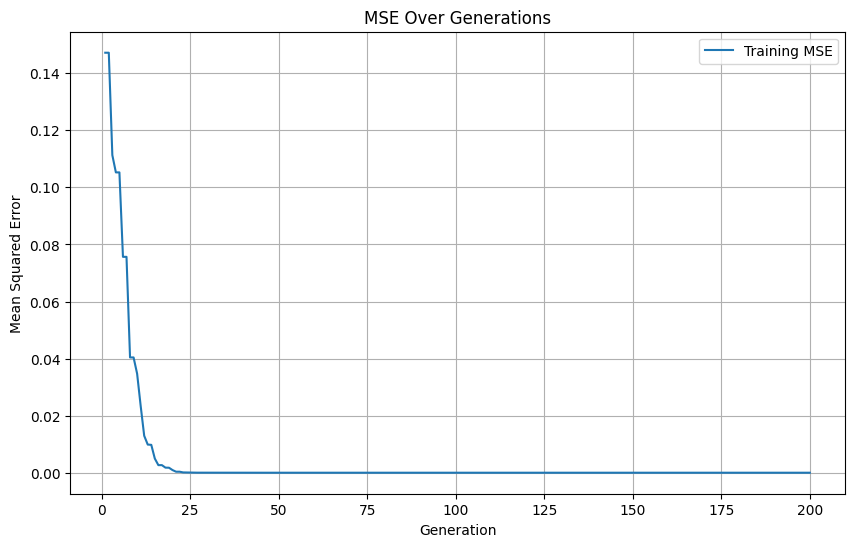

In [41]:
# Run GA
st_time=time.time()
best_genome, mse_history = run_genetic_algorithm(
    nn=nn,
    X=X_train,
    y=y_train,
    population_size=100,
    generations=200,
    mutation_rate=0.1,
    elitism=10
)

# Decode best genome
best_weights, best_biases = decode_genome(best_genome, nn.layer_sizes)

# Compute final MSE on training set
final_predictions = nn.forward(X_train, best_weights, best_biases)
final_mse = np.mean((final_predictions - y_train) ** 2)
print(f"\nFinal MSE on Training Set: {final_mse}")

# Compute MSE on test set
test_predictions = nn.forward(X_test, best_weights, best_biases)
test_mse = np.mean((test_predictions - y_test) ** 2)
final_time= time.time() -st_time
print(f"Final MSE on Test Set: {test_mse}")
print(f"Total runtime : {final_time}")
# Plot MSE over generations
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_history)+1), mse_history, label='Training MSE')
plt.xlabel('Generation')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Generations')
plt.legend()
plt.grid(True)
plt.show()

Mutation rate of 40% :

Generation 1: Best MSE = 0.11733750266647987
Generation 10: Best MSE = 0.015435889623035853
Generation 20: Best MSE = 8.5219332588737e-05
Generation 30: Best MSE = 1.0286984008632197e-06
Generation 40: Best MSE = 1.0000039537551098e-06
Generation 50: Best MSE = 1.0000000003193909e-06
Generation 60: Best MSE = 1.0000000000000055e-06
Generation 70: Best MSE = 1e-06
Generation 80: Best MSE = 1e-06
Generation 90: Best MSE = 1e-06
Generation 100: Best MSE = 1e-06
Generation 110: Best MSE = 1e-06
Generation 120: Best MSE = 1e-06
Generation 130: Best MSE = 1e-06
Generation 140: Best MSE = 1e-06
Generation 150: Best MSE = 1e-06
Generation 160: Best MSE = 1e-06
Generation 170: Best MSE = 1e-06
Generation 180: Best MSE = 1e-06
Generation 190: Best MSE = 1e-06
Generation 200: Best MSE = 1e-06

Final MSE on Training Set: 1.054603763282596e-22
Final MSE on Test Set: 7.835664592517562e-23
Total runtime : 35.53202486038208


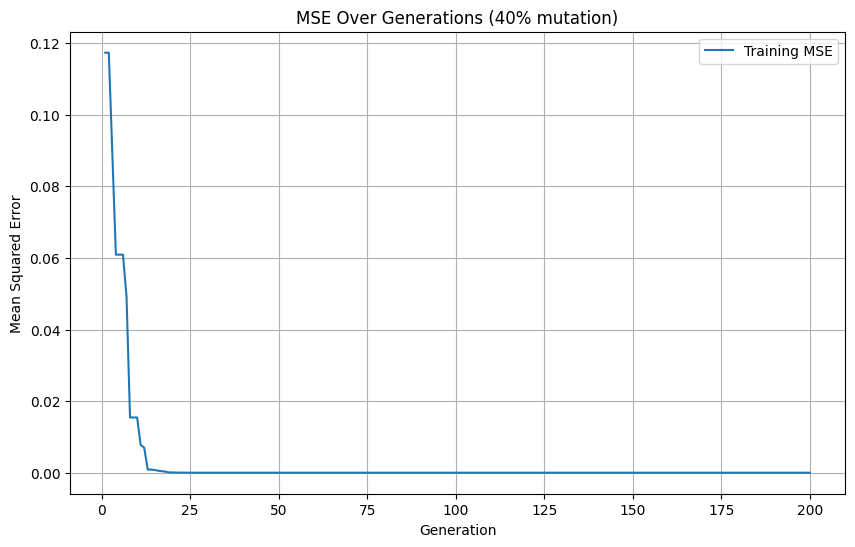

In [42]:
# Run GA
st_time =time.time()
best_genome, mse_history = run_genetic_algorithm(
    nn=nn,
    X=X_train,
    y=y_train,
    population_size=100,
    generations=200,
    mutation_rate=0.40,
    elitism=10
)

# Decode best genome
best_weights, best_biases = decode_genome(best_genome, nn.layer_sizes)

# Compute final MSE on training set
final_predictions = nn.forward(X_train, best_weights, best_biases)
final_mse = np.mean((final_predictions - y_train) ** 2)
print(f"\nFinal MSE on Training Set: {final_mse}")

# Compute MSE on test set
test_predictions = nn.forward(X_test, best_weights, best_biases)
test_mse = np.mean((test_predictions - y_test) ** 2)
final_time=time.time()- st_time
print(f"Final MSE on Test Set: {test_mse}")
print(f"Total runtime : {final_time}")
# Plot MSE over generations
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_history)+1), mse_history, label='Training MSE')
plt.xlabel('Generation')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Generations (40% mutation)')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1: MSE = 0.2671507758385443
Epoch 10: MSE = 0.26356720159899305
Epoch 20: MSE = 0.2596988302359769
Epoch 30: MSE = 0.25595253036100973
Epoch 40: MSE = 0.25232994059363384
Epoch 50: MSE = 0.24883156553630975
Epoch 60: MSE = 0.24545687262845511
Epoch 70: MSE = 0.24220440135191906
Epoch 80: MSE = 0.2390718798387916
Epoch 90: MSE = 0.23605634436222545
Epoch 100: MSE = 0.23315425778360513
Epoch 110: MSE = 0.23036162371562607
Epoch 120: MSE = 0.22767409387892976
Epoch 130: MSE = 0.22508706682953844
Epoch 140: MSE = 0.22259577687815757
Epoch 150: MSE = 0.22019537258608426
Epoch 160: MSE = 0.2178809846931437
Epoch 170: MSE = 0.21564778370738724
Epoch 180: MSE = 0.21349102766795292
Epoch 190: MSE = 0.21140610079003508
Epoch 200: MSE = 0.20938854382567165

Final MSE on Training Set: 0.20938854382567165
Final MSE on Test Set: 0.20205529374010875
Total runtime : 1.2750000953674316


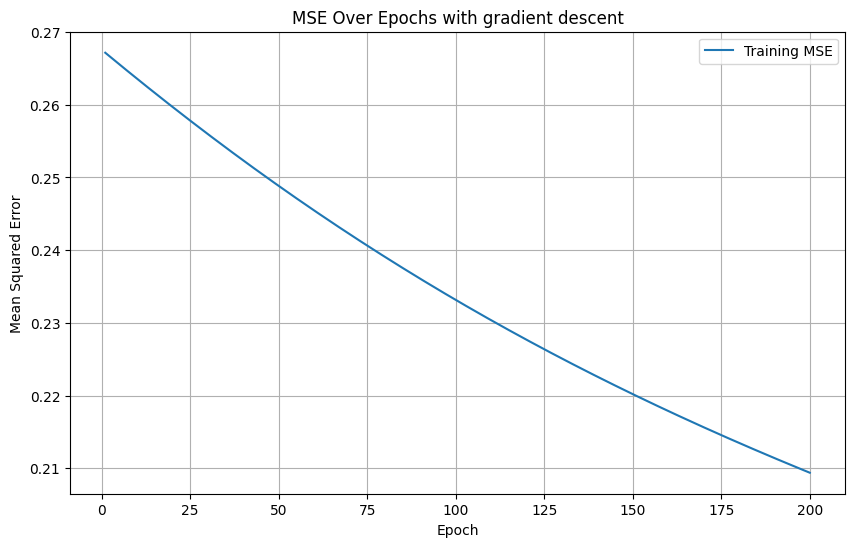

In [43]:

class NeuralNetworkGD:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.weights = []
        self.biases = []
        for i in range(len(self.layer_sizes) - 1):
            weight = np.random.uniform(-1, 1, (self.layer_sizes[i], self.layer_sizes[i+1]))
            bias = np.random.uniform(-1, 1, (1, self.layer_sizes[i+1]))
            self.weights.append(weight)
            self.biases.append(bias)
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_derivative(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def forward(self, X):
        activations = [X]
        zs = []  # Store the intermediate z values
        a = X
        for w, b in zip(self.weights, self.biases):
            z = np.dot(a, w) + b
            zs.append(z)
            a = self.sigmoid(z)
            activations.append(a)
        return activations, zs
    
    def compute_gradients(self, X, y):
        # Forward pass
        activations, zs = self.forward(X)
        output = activations[-1]
        
        # Backward pass (compute gradients)
        grads_w = [np.zeros_like(w) for w in self.weights]
        grads_b = [np.zeros_like(b) for b in self.biases]
        
        # Output layer error
        delta = (output - y) * self.sigmoid_derivative(zs[-1])
        
        grads_w[-1] = np.dot(activations[-2].T, delta) / X.shape[0]
        grads_b[-1] = np.mean(delta, axis=0, keepdims=True)
        
        # Propagate errors backwards through hidden layers
        for l in range(2, len(self.layer_sizes)):
            delta = np.dot(delta, self.weights[-l + 1].T) * self.sigmoid_derivative(zs[-l])
            grads_w[-l] = np.dot(activations[-l - 1].T, delta) / X.shape[0]
            grads_b[-l] = np.mean(delta, axis=0, keepdims=True)
        
        return grads_w, grads_b
    
    def update_parameters(self, grads_w, grads_b, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * grads_w[i]
            self.biases[i] -= learning_rate * grads_b[i]

# 3. Training with Gradient Descent
def train_nn(nn, X, y, epochs=200, learning_rate=0.01):
    mse_history = []
    for epoch in range(epochs):
        # Compute gradients
        grads_w, grads_b = nn.compute_gradients(X, y)
        # Update weights and biases
        nn.update_parameters(grads_w, grads_b, learning_rate)
        
        # Calculate mean squared error
        predictions = nn.forward(X)[0][-1]
        mse = np.mean((predictions - y) ** 2)
        mse_history.append(mse)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}: MSE = {mse}")
    
    return mse_history

# Initialize neural network
nn = NeuralNetworkGD(input_size=4, hidden_sizes=[16, 16], output_size=1)
st_time=time.time()
# Train with gradient descent
mse_history = train_nn(nn, X_train, y_train, epochs=200, learning_rate=0.01)

# Compute final MSE on training set
final_predictions = nn.forward(X_train)[0][-1]
final_mse = np.mean((final_predictions - y_train) ** 2)
print(f"\nFinal MSE on Training Set: {final_mse}")

# Compute MSE on test set
test_predictions = nn.forward(X_test)[0][-1]
test_mse = np.mean((test_predictions - y_test) ** 2)
final_time=time.time() -st_time
print(f"Final MSE on Test Set: {test_mse}")
print(f"Total runtime : {final_time}")
# Plot MSE over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_history) + 1), mse_history, label='Training MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Epochs with gradient descent')
plt.legend()
plt.grid(True)
plt.show()


# Bonus

We decided to go a little bit further in the optimization of our NN.

We are going to use other optimizer to see the effectiveness of the gradient descent for our problem.

The two most common optimizer in deep learning are ADAM and RMSPROP.

ADAM OPTIMIZER

We keep the same class architecture and just modify it to take into account the Adam optimizer (already pre built through a library)

Epoch 1: MSE = 0.3681943775259631
Epoch 10: MSE = 0.14786739860917814
Epoch 20: MSE = 0.06811140301839742
Epoch 30: MSE = 0.028212629292070614
Epoch 40: MSE = 0.012384734198475722
Epoch 50: MSE = 0.006421840956408262
Epoch 60: MSE = 0.004091803623222785
Epoch 70: MSE = 0.0029276689454292614
Epoch 80: MSE = 0.002267283148660681
Epoch 90: MSE = 0.0018471269168123538
Epoch 100: MSE = 0.0015526492372801997
Epoch 110: MSE = 0.0013324715720082181
Epoch 120: MSE = 0.0011608791720322074
Epoch 130: MSE = 0.0010232937133000059
Epoch 140: MSE = 0.0009106430773609209
Epoch 150: MSE = 0.0008168999686525099
Epoch 160: MSE = 0.000737860198383333
Epoch 170: MSE = 0.0006704802991760818
Epoch 180: MSE = 0.0006124936346035741
Epoch 190: MSE = 0.0005621744822992164
Epoch 200: MSE = 0.0005181854832782897

Final MSE on Training Set: 0.0005181854832782897
Final MSE on Test Set: 0.00048126146613345115
Total runtime : 0.9129884243011475


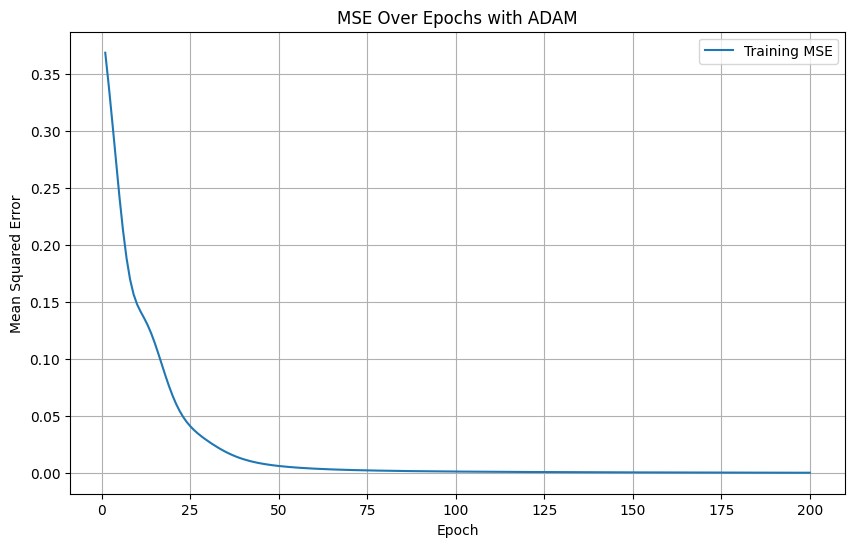

In [ ]:

class NeuralNetworkAdam:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.weights = []
        self.biases = []
        
        # Initialize weights and biases
        for i in range(len(self.layer_sizes) - 1):
            weight = np.random.uniform(-1, 1, (self.layer_sizes[i], self.layer_sizes[i+1]))
            bias = np.random.uniform(-1, 1, (1, self.layer_sizes[i+1]))
            self.weights.append(weight)
            self.biases.append(bias)
        
        # Adam optimizer variables
        self.m_w = [np.zeros_like(w) for w in self.weights]
        self.v_w = [np.zeros_like(w) for w in self.weights]
        self.m_b = [np.zeros_like(b) for b in self.biases]
        self.v_b = [np.zeros_like(b) for b in self.biases]
        self.t = 0  # Timestep for Adam
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_derivative(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def forward(self, X):
        activations = [X]
        zs = []  # Store intermediate z values
        a = X
        for w, b in zip(self.weights, self.biases):
            z = np.dot(a, w) + b
            zs.append(z)
            a = self.sigmoid(z)
            activations.append(a)
        return activations, zs
    
    def compute_gradients(self, X, y):
        # Forward pass
        activations, zs = self.forward(X)
        output = activations[-1]
        
        # Backward pass (compute gradients)
        grads_w = [np.zeros_like(w) for w in self.weights]
        grads_b = [np.zeros_like(b) for b in self.biases]
        
        # Output layer error
        delta = (output - y) * self.sigmoid_derivative(zs[-1])
        
        grads_w[-1] = np.dot(activations[-2].T, delta) / X.shape[0]
        grads_b[-1] = np.mean(delta, axis=0, keepdims=True)
        
        # Propagate errors backwards through hidden layers
        for l in range(2, len(self.layer_sizes)):
            delta = np.dot(delta, self.weights[-l + 1].T) * self.sigmoid_derivative(zs[-l])
            grads_w[-l] = np.dot(activations[-l - 1].T, delta) / X.shape[0]
            grads_b[-l] = np.mean(delta, axis=0, keepdims=True)
        
        return grads_w, grads_b
    
    def update_parameters_adam(self, grads_w, grads_b, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.t += 1
        for i in range(len(self.weights)):
            # Update biased first moment estimate for weights
            self.m_w[i] = beta1 * self.m_w[i] + (1 - beta1) * grads_w[i]
            # Update biased second moment estimate for weights
            self.v_w[i] = beta2 * self.v_w[i] + (1 - beta2) * (grads_w[i] ** 2)
            # Correct bias in first moment for weights
            m_w_hat = self.m_w[i] / (1 - beta1 ** self.t)
            # Correct bias in second moment for weights
            v_w_hat = self.v_w[i] / (1 - beta2 ** self.t)
            # Update weights
            self.weights[i] -= learning_rate * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
            
            # Repeat the same for biases
            self.m_b[i] = beta1 * self.m_b[i] + (1 - beta1) * grads_b[i]
            self.v_b[i] = beta2 * self.v_b[i] + (1 - beta2) * (grads_b[i] ** 2)
            m_b_hat = self.m_b[i] / (1 - beta1 ** self.t)
            v_b_hat = self.v_b[i] / (1 - beta2 ** self.t)
            self.biases[i] -= learning_rate * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

# 3. Training with Adam Optimizer
def train_nn_adam(nn, X, y, epochs=200, learning_rate=0.01):
    mse_history = []
    for epoch in range(epochs):
        # Compute gradients
        grads_w, grads_b = nn.compute_gradients(X, y)
        # Update weights and biases with Adam
        nn.update_parameters_adam(grads_w, grads_b, learning_rate)
        
        # Calculate mean squared error
        predictions = nn.forward(X)[0][-1]
        mse = np.mean((predictions - y) ** 2)
        mse_history.append(mse)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}: MSE = {mse}")
    
    return mse_history

# Initialize neural network
nn = NeuralNetworkAdam(input_size=4, hidden_sizes=[16, 16], output_size=1)

st_time=time.time()
# Train with Adam optimizer
mse_history = train_nn_adam(nn, X_train, y_train, epochs=200, learning_rate=0.01)

# Compute final MSE on training set
final_predictions = nn.forward(X_train)[0][-1]
final_mse = np.mean((final_predictions - y_train) ** 2)
print(f"\nFinal MSE on Training Set: {final_mse}")

# Compute MSE on test set
test_predictions = nn.forward(X_test)[0][-1]
test_mse = np.mean((test_predictions - y_test) ** 2)
final_time=time.time()-st_time
print(f"Final MSE on Test Set: {test_mse}")
print(f"Total runtime : {final_time}")
# Plot MSE over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_history) + 1), mse_history, label='Training MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Epochs with ADAM')
plt.legend()
plt.grid(True)
plt.show()


RMSPROP OPTIMIZER

Exactly the same principle as for Adam, we keep the same class and modify it for our needs.

Epoch 1: MSE = 0.3536103716240905
Epoch 10: MSE = 0.06419520071735396
Epoch 20: MSE = 0.01573049563650405
Epoch 30: MSE = 0.005779339819977139
Epoch 40: MSE = 0.0025384830353197855
Epoch 50: MSE = 0.0012251235531460277
Epoch 60: MSE = 0.0006265477816831381
Epoch 70: MSE = 0.0003332432598695605
Epoch 80: MSE = 0.00018230639104755645
Epoch 90: MSE = 0.00010187953703995594
Epoch 100: MSE = 5.7900548052099936e-05
Epoch 110: MSE = 3.336012990960186e-05
Epoch 120: MSE = 1.9438437434349193e-05
Epoch 130: MSE = 1.1431838019316204e-05
Epoch 140: MSE = 6.774792470869327e-06
Epoch 150: MSE = 4.040907813583513e-06
Epoch 160: MSE = 2.4239142377939825e-06
Epoch 170: MSE = 1.4616226768041259e-06
Epoch 180: MSE = 8.8598730148136e-07
Epoch 190: MSE = 5.40083070276707e-07
Epoch 200: MSE = 3.313448852068731e-07

Final MSE on Training Set: 3.313448852068731e-07
Final MSE on Test Set: 2.9655497483344393e-07
Total runtime : 0.90199875831604


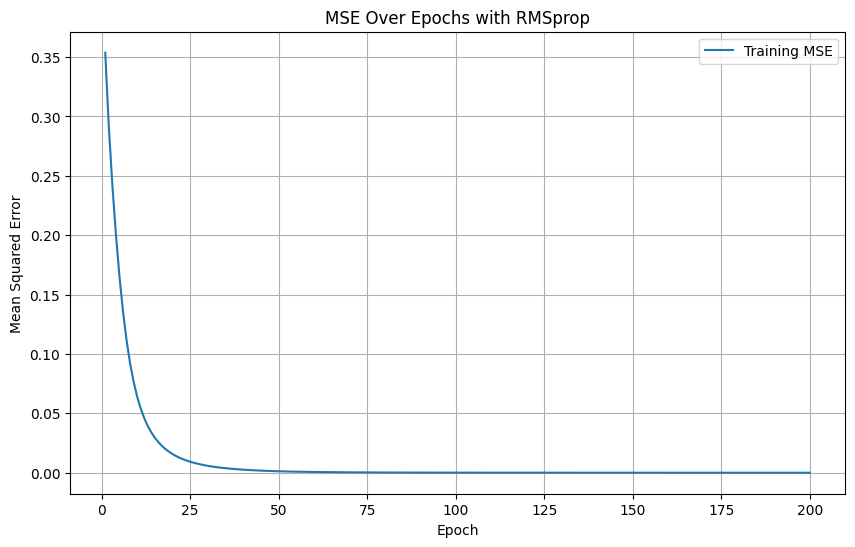

In [45]:

class NeuralNetworkRMS:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.weights = []
        self.biases = []
        
        # Initialize weights and biases
        for i in range(len(self.layer_sizes) - 1):
            weight = np.random.uniform(-1, 1, (self.layer_sizes[i], self.layer_sizes[i+1]))
            bias = np.random.uniform(-1, 1, (1, self.layer_sizes[i+1]))
            self.weights.append(weight)
            self.biases.append(bias)
        
        # RMSprop variables for adaptive learning rate
        self.s_w = [np.zeros_like(w) for w in self.weights]
        self.s_b = [np.zeros_like(b) for b in self.biases]
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_derivative(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def forward(self, X):
        activations = [X]
        zs = []  # Store intermediate z values
        a = X
        for w, b in zip(self.weights, self.biases):
            z = np.dot(a, w) + b
            zs.append(z)
            a = self.sigmoid(z)
            activations.append(a)
        return activations, zs
    
    def compute_gradients(self, X, y):
        # Forward pass
        activations, zs = self.forward(X)
        output = activations[-1]
        
        # Backward pass (compute gradients)
        grads_w = [np.zeros_like(w) for w in self.weights]
        grads_b = [np.zeros_like(b) for b in self.biases]
        
        # Output layer error
        delta = (output - y) * self.sigmoid_derivative(zs[-1])
        
        grads_w[-1] = np.dot(activations[-2].T, delta) / X.shape[0]
        grads_b[-1] = np.mean(delta, axis=0, keepdims=True)
        
        # Propagate errors backwards through hidden layers
        for l in range(2, len(self.layer_sizes)):
            delta = np.dot(delta, self.weights[-l + 1].T) * self.sigmoid_derivative(zs[-l])
            grads_w[-l] = np.dot(activations[-l - 1].T, delta) / X.shape[0]
            grads_b[-l] = np.mean(delta, axis=0, keepdims=True)
        
        return grads_w, grads_b
    
    def update_parameters_rmsprop(self, grads_w, grads_b, learning_rate, beta=0.9, epsilon=1e-8):
        for i in range(len(self.weights)):
            # Update second moment estimates for weights
            self.s_w[i] = beta * self.s_w[i] + (1 - beta) * (grads_w[i] ** 2)
            # Update weights with adaptive learning rate
            self.weights[i] -= learning_rate * grads_w[i] / (np.sqrt(self.s_w[i]) + epsilon)
            
            # Repeat the same for biases
            self.s_b[i] = beta * self.s_b[i] + (1 - beta) * (grads_b[i] ** 2)
            self.biases[i] -= learning_rate * grads_b[i] / (np.sqrt(self.s_b[i]) + epsilon)

# 3. Training with RMSprop Optimizer
def train_nn_rmsprop(nn, X, y, epochs=200, learning_rate=0.01):
    mse_history = []
    for epoch in range(epochs):
        # Compute gradients
        grads_w, grads_b = nn.compute_gradients(X, y)
        # Update weights and biases with RMSprop
        nn.update_parameters_rmsprop(grads_w, grads_b, learning_rate)
        
        # Calculate mean squared error
        predictions = nn.forward(X)[0][-1]
        mse = np.mean((predictions - y) ** 2)
        mse_history.append(mse)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}: MSE = {mse}")
    
    return mse_history

# Initialize neural network
nn = NeuralNetworkRMS(input_size=4, hidden_sizes=[16, 16], output_size=1)
st_time=time.time()
# Train with RMSprop optimizer
mse_history = train_nn_rmsprop(nn, X_train, y_train, epochs=200, learning_rate=0.01)

# Compute final MSE on training set
final_predictions = nn.forward(X_train)[0][-1]
final_mse = np.mean((final_predictions - y_train) ** 2)
print(f"\nFinal MSE on Training Set: {final_mse}")

# Compute MSE on test set
test_predictions = nn.forward(X_test)[0][-1]
test_mse = np.mean((test_predictions - y_test) ** 2)
final_time=time.time() -st_time
print(f"Final MSE on Test Set: {test_mse}")
print(f"Total runtime : {final_time}")
# Plot MSE over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_history) + 1), mse_history, label='Training MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Epochs with RMSprop')
plt.legend()
plt.grid(True)
plt.show()


## Convergence results analysis : 

### GA optimizer: 
Final MSE on Training Set: 4.427666289610404e-23

Final MSE on Test Set: 4.2100074639427575e-23

Total runtime : 27.917064666748047

### GA optimizer (40% mutation):
Final MSE on Training Set: 1.054603763282596e-22

Final MSE on Test Set: 7.835664592517562e-23

Total runtime : 35.53202486038208

### Gradient descent optimizer :
Final MSE on Training Set: 0.20938854382567165

Final MSE on Test Set: 0.20205529374010875

Total runtime : 1.2750000953674316

### Adam optimizer : 

Final MSE on Training Set: 0.0005181854832782897

Final MSE on Test Set: 0.00048126146613345115

Total runtime : 0.9129884243011475

### RMSProp optimizer 
Final MSE on Training Set: 3.313448852068731e-07

Final MSE on Test Set: 2.9655497483344393e-07

Total runtime : 0.90199875831604

# Discussion

Here’s a detailed analysis:

 ## 1. Performance of Genetic Algorithm (GA) Optimizers

Standard GA achieved near-perfect performance with a very low MSE on both the training set (4.427e-23) and the test set (4.210e-23). However, it had the longest runtime (27.9 seconds).
GA with Higher Mutation Rate (40%) showed slightly higher MSE values (1.05e-22 on training and 7.83e-23 on test), indicating reduced performance due to the more aggressive mutation rate possibly disrupting convergence. Additionally, the runtime increased to 35.5 seconds, reflecting the additional computational cost of handling a higher mutation rate.

## 2. Traditional Gradient Descent and Variants

### Gradient Descent
Gradient Descent yielded comparatively higher MSE values (0.209 on training and 0.202 on test) and had a relatively short runtime of 1.27 seconds. This performance indicates it was less capable of finding an optimal solution, likely due to the complexity of the problem and potential difficulty in navigating the error surface.

### Adam Optimizer
Adam Optimizer performed significantly better than standard gradient descent, with MSE values of 0.0005 (training) and 0.00048 (test) and a very fast runtime (0.91 seconds). This highlights Adam's ability to adapt learning rates during training, leading to faster and more accurate convergence.

### RMSProp Optimizer
RMSProp Optimizer showed exceptional performance with an extremely low MSE (3.31e-07 on training and 2.97e-07 on test) while maintaining the shortest runtime (0.90 seconds). This indicates its effectiveness in handling optimization for this neural network setup, particularly with non-stationary learning rates.

## 3. Comparison and Insights

### Accuracy vs. Runtime Tradeoff: 
GAs achieved remarkably low MSE values, outperforming traditional methods in terms of accuracy. However, they required significantly longer runtimes, indicating a tradeoff between precision and computational efficiency. Among traditional optimizers, RMSProp provided the best balance of accuracy and runtime.

### GA Parameters: 
The introduction of a higher mutation rate (40%) reduced the performance of the GA optimizer, suggesting that overly aggressive mutations can hinder the algorithm’s ability to converge to an optimal solution.

### Problem Complexity and Solution Space: 
The neural network's weight and bias optimization problem involves navigating a complex, high-dimensional error surface. GAs excel in exploring this space but at the cost of computational efficiency. In contrast, gradient-based methods rely on local gradient information, making them faster but potentially less effective in finding global minima.

## 4. Advantages and Limitations of GAs

### Advantages:
GAs are not dependent on gradient information, making them suitable for non-differentiable or highly irregular loss surfaces.
They can effectively escape local minima due to their stochastic nature and population-based search.
They offer flexibility in exploring diverse solutions through crossover and mutation.

### Limitations:
High computational cost, particularly with large populations or complex networks.
Sensitivity to parameter settings (e.g., population size, mutation rate), requiring careful tuning to achieve optimal performance.
Slower convergence compared to gradient-based optimizers, especially for problems where gradients are well-defined and smooth.

# Conclusion

For optimizing the neural network weights and biases, GAs demonstrated superior accuracy at the expense of runtime. Traditional optimizers like Adam and RMSProp offered a more practical tradeoff for scenarios demanding both efficiency and reasonable accuracy. GAs remain a powerful tool for complex optimization problems where traditional methods struggle, but they seem to require computational resources and parameter fine-tuning to realize their potential effectively.